In [47]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [36]:
df = pd.read_csv("/Users/lennertsteyaert/Documents/GitHub/computervisie-group8/src/data/matchingscores.csv")
df

,Unnamed: 0,filename,result_50_features,distance_50_features,time_50_features,result_100_features,distance_100_features,time_100_features,result_200_features,distance_200_features,time_200_features,result_300_features,distance_300_features,time_300_features
0,0,20190217_110001.jpg,[],[],[],[],[],[],[],[],[],[],[],[]
1,1,20190217_104706.jpg,['zaal_2__IMG_20190323_112235__01.png'],[329.0],[0.2768612919999782],['zaal_2__IMG_20190323_112235__01.png'],[237.0],[0.2952983749999589],['zaal_2__IMG_20190323_112235__01.png'],[203.0],[0.4169997079999348],['zaal_2__IMG_20190323_112235__01.png'],[165.0],[0.5390496659999826]
2,2,20190217_104510.jpg,['zaal_6__IMG_20190323_112938__01.png'],[470.0],"[0.24806375000000003, 0.24814241699999684]","['zaal_6__IMG_20190323_112938__01.png', 'Zaal_...","[294.0, 905.0]","[0.28201783399998703, 0.2935176249999927]","['zaal_6__IMG_20190323_112938__01.png', 'zaal_...","[230.0, 678.0]","[0.41200175000005856, 0.40726679099998364]","['zaal_6__IMG_20190323_112938__01.png', 'zaal_...","[207.0, 544.0]","[0.5230352920000314, 0.515774040999986]"
3,3,20190217_105140.jpg,['zaal_5__IMG_20190323_112800__01.png'],[1382.0],[0.26245499999998856],['zaal_18__IMG_20190323_120704__01.png'],[429.0],[0.28619083299997783],['zaal_18__IMG_20190323_120704__01.png'],[317.0],[0.4157244589999891],['zaal_18__IMG_20190323_120704__01.png'],[304.0],[0.5265022080000108]
4,4,20190217_105829.jpg,['Zaal_M__20190323_123139__01.png'],[404.0],[0.23901558399998635],['Zaal_M__20190323_123139__01.png'],[330.0],[0.2730836250000266],['Zaal_M__20190323_123139__01.png'],[283.0],[0.40890779199992267],['Zaal_M__20190323_123139__01.png'],[244.0],[0.5252378750001299]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,231,20190217_103105.jpg,[],[],[],[],[],[],[],[],[],[],[],[]
232,232,20190217_110151.jpg,['Zaal_G__20190323_120351__01.png'],[505.0],[0.23930412499998965],['Zaal_G__20190323_120351__01.png'],[346.0],[0.2786704999999756],['Zaal_G__20190323_120351__01.png'],[292.0],[0.4143359170000167],['Zaal_G__20190323_120351__01.png'],[271.0],[0.5609456669999417]
233,233,20190217_102555.jpg,['zaal_19__IMG_20190323_121300__01.png'],[1072.0],[0.24450400000000627],['zaal_19__IMG_20190323_121300__01.png'],[538.0],[0.278391332999945],['zaal_19__IMG_20190323_121300__01.png'],[355.0],[0.4551981250000381],['zaal_19__IMG_20190323_121300__01.png'],[329.0],[0.548135375000129]
234,234,20190217_110623.jpg,['Zaal_M__20190323_123139__01.png'],[1281.0],[0.2422739170000341],['Zaal_C__20190323_112836__08.png'],[754.0],[0.27716470899997603],['Zaal_C__20190323_112836__08.png'],[590.0],[0.5905868749999854],['Zaal_C__20190323_112836__08.png'],[480.0],[0.5269227079998018]


In [37]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable as V
from PIL import Image

class CustomResNet():
    def __init__(self):
        self.model = models.resnet18()
        self.model.eval()
    
    def get_feature_vector(self, img_path):
        # https://towardsdatascience.com/recommending-similar-images-using-pytorch-da019282770c

        feature_layer = self.model.avgpool
        feature_vector = torch.zeros(1, 512, 1, 1)

        # Define image manipulations and process image using standard ResNet parameters.
        img =  Image.open(img_path) if isinstance(img_path, str) else Image.fromarray(img_path)
        centre_crop = transforms.Compose([
            # #transforms.Resize((224,224)),
            # transforms.CenterCrop(224),
            # #transforms.RandomResizedCrop(224),
            # transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

            transforms.Resize(224),
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        processed_img = V(centre_crop(img).unsqueeze(0))
        
        # Register hook in the forward pass that copies the feature vector out
        # of the Neural Net.

        def copy_hook(m, i, o):
            feature_vector.copy_(o.data)
        h = feature_layer.register_forward_hook(copy_hook)

        # Apply forward pass
        fp = self.model.forward(processed_img) 
        
        h.remove()
        return feature_vector.numpy()[0, :, 0, 0]


In [38]:
neuralnet = CustomResNet()

img_path = "/Users/lennertsteyaert/Documents/GitHub/computervisie-group8/data/Database/zaal_1__IMG_20190323_111717__01.png"

vectors = neuralnet.get_feature_vector(img_path).tolist()

In [39]:

def convert_descriptors(descriptors):
    descriptors = np.array(pd.read_json(descriptors), dtype=np.uint8)
    return descriptors


def convert_fvector(fvectors):
    descriptors = np.array(pd.read_json(fvectors), dtype=np.float32)
    return descriptors


def convert_keypoints(keypoint_array):
    keypoints_result = []
    keypoint_array  =  np.array(pd.read_json(keypoint_array))
    for  p in keypoint_array:
        temp = cv2.KeyPoint(
            x=p[0][0],
            y=p[0][1],
            size=p[1],
            angle=p[2],
            response=p[3],
            octave=p[4],
            class_id=p[5],
        )
        keypoints_result.append(temp)
    return keypoints_result

In [40]:
db = pd.read_csv("/Users/lennertsteyaert/Documents/GitHub/computervisie-group8/src/data/keypoints.csv", ",")
# db['descriptors'] = db['descriptors'].apply(lambda x: convert_descriptors(x))
# db['keypoints'] = db['keypoints'].apply(lambda x: convert_keypoints(x))
db['fvector'] = db['fvector'].apply(lambda x: convert_fvector(x))

/Users/lennertsteyaert/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
db['fvector'].head()

0    [[0.070071466], [0.90222675], [1.2653224], [0....
1    [[0.17483094], [1.7130778], [1.9954283], [0.02...
2    [[0.20440161], [1.500054], [1.7981013], [0.044...
3    [[0.03168553], [0.5974089], [1.1616629], [0.00...
4    [[0.13452241], [1.2443517], [1.5722752], [0.02...
Name: fvector, dtype: object

In [42]:
from scipy.spatial import distance



similar_idx_cosine = [ distance.cosine(vectors, feat) for feat in db['fvector'] ]

In [43]:
idx_closest = sorted(range(len(similar_idx_cosine)), key=lambda k: similar_idx_cosine[k])[1:6]

In [46]:
#print(idx_closest)
for name in db.iloc[idx_closest].id:
    print(name)

zaal_S__IMG_20190323_122919__04.png
Zaal_B__20190323_112302__01.png
zaal_19__IMG_20190323_121523__02.png
Zaal_M__20190323_123750__01.png
Zaal_J__20190323_121919__01.png


In [48]:
def load_image(img_path):
    img =  Image.open(img_path) if isinstance(img_path, str) else Image.fromarray(img_path)
    return img

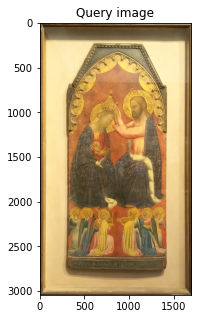

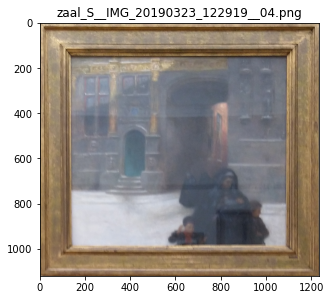

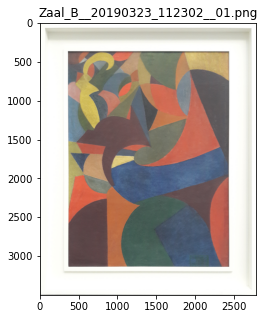

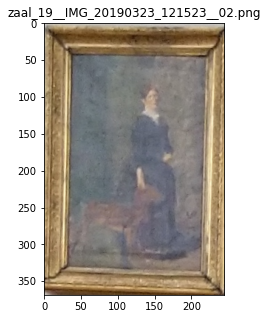

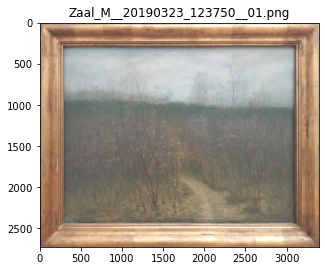

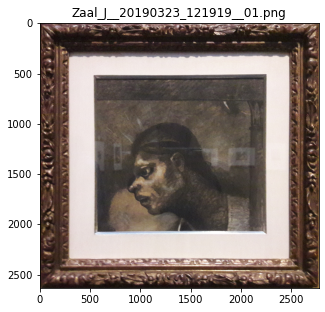

In [51]:
plt.figure(figsize = (5,5))
plt.imshow(load_image(img_path))
plt.title("Query image")

directory = "/Users/lennertsteyaert/Documents/GitHub/computervisie-group8/data/Database/"


for name in db.iloc[idx_closest].id:
    img = load_image(directory +  name)
    plt.figure(figsize = (5,5))
    plt.imshow(img)
    plt.title(name)